In [67]:
from fastai2.vision.all import *
import matplotlib.pyplot as plt
from pydicom import dcmread
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy import ndimage

In [2]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
path.ls()

(#6) [Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/test.csv'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/train'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/train.csv'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/test'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/osic-pulmonary-fibrosis-progression.zip'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/sample_submission.csv')]

In [4]:
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [5]:
train_path = path/'train'
test_path = path/'test'
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')

In [75]:
test_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [76]:
sample_sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [6]:
#returns a list with the dicoms in order
def dcm_sort(patient_folder):
    #list comprehension that runs through folder of dicoms
    dcm_stacked = [dcmread(dcm) for dcm in patient_folder.ls()]
    dcm_stacked.sort(key=lambda x: int(x.InstanceNumber), reverse=True)
    #returning a python list of dicoms sorted
    return dcm_stacked

#transforms all slices in a scan in hounsfield units 
def ct_transformed_hu(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [7]:
#transforms all slices in a scan in hounsfield units 
def ct_transformed_hu(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [11]:
one_scan = dcm_sort(train_path.ls()[19])
scan_hu = ct_transformed_hu(one_scan, replace=0)
len(one_scan)

64

In [80]:
vol = torch.from_numpy(scan_hu).float()
vol.shape, vol.type

(torch.Size([64, 512, 512]), <function Tensor.type>)

In [135]:
volz = vol[None][None]
volz.shape

torch.Size([1, 1, 64, 512, 512])

In [161]:
conv = nn.Conv3d(1, 1, kernel_size=(2,3,3), padding=1)
conv

Conv3d(1, 1, kernel_size=(2, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

In [162]:
#??nn.Conv3d

In [163]:
conv.weight.shape, conv.bias.shape

(torch.Size([1, 1, 2, 3, 3]), torch.Size([1]))

In [164]:
conv(volz).shape

torch.Size([1, 1, 65, 512, 512])

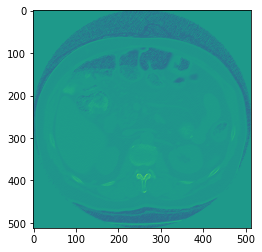

In [165]:
plt.imshow(conv(volz).squeeze(0).squeeze(0).detach().numpy()[0])